# Calculate the seasonal means of errors in MDM and QDM+ sort predictions
- MDM: Moment Delta Mapping
- Consider the MDM operators L_1 and L_2 which map the mean and mean and stdev of a distribution respectively
- MDM error for operator L_i  = [L_i (Q_historical) ] - Q_future
- In this notebook, Q_historical is the pre-industrial quantile function and Q_future is the End of 21st century quantile function
- These quantile functions are constructed from detrended CESM2 LENS data
- We can similarly caluclate errors for the Gaussian operators G1 and G2 (see paper for more details)
- In this notebook, we compute the seasonal mean of the MDM error for various operators

## Section 1: Load functions and start a cluster

In [4]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import cartopy as cart
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [5]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [6]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
#SGP
sgp_lat   = 36.605
sgp_lon   = (360-97.485)%360
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url     =  'https://data.rda.ucar.edu/'
rda_data    = '/gpfs/csfs1/collections/rda/data/harshah/'
#
tmean_path  = rda_data + 'mdm_data/tmean/'
tmax_path   = rda_data + 'mdm_data/tmax/'
tmin_path   = rda_data + 'mdm_data/tmin/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [7]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [8]:
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_shift(ds_obs,init_mean,final_mean):
    # Assuming coordinates year and day for ds_obs
    obs_mean   = ds_obs.mean('year')
    ds_shift   = obs_mean + (final_mean - init_mean) + ds_obs - obs_mean        
    return ds_shift

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

In [9]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [10]:
def select_months(data, months):
    """
    Selects data for specific months from an xarray DataArray based on dayofyear and year coordinates.

    Parameters:
    data (xarray.DataArray): The input DataArray with 'dayofyear' and 'year' coordinates.
    months (list of int): List of three months to select (e.g., [12, 1, 2] for DJF).

    Returns:
    xarray.DataArray: Filtered DataArray for the specified months.
    """
    # Define the day ranges for each month assuming a 365-day calendar
    month_ranges = {
        1: (1, 31),   # January
        2: (32, 59),  # February
        3: (60, 90),  # March
        4: (91, 120), # April
        5: (121, 151),# May
        6: (152, 181),# June
        7: (182, 212),# July
        8: (213, 243),# August
        9: (244, 273),# September
        10: (274, 304),# October
        11: (305, 334),# November
        12: (335, 365)# December
    }

    # Get the start and end day of the year for each selected month
    days_to_select = []
    for month in months:
        start_day, end_day = month_ranges[month]
        days_to_select.extend(range(start_day, end_day + 1))

    # Filter the data for the specified days of the year
    filtered_data = data.where(data['dayofyear'].isin(days_to_select), drop=True)

    return filtered_data

In [11]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [12]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25-mdm',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    log_directory = rda_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43241 instead
  warnings.warn(


In [13]:
# Create the client to load the Dashboard
client = Client(cluster)

In [14]:
n_workers = 8
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(ac92c488, 'tcp://128.117.208.98:35529', workers=8, threads=8, memory=128.00 GiB)

In [15]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
# eoc_year = 2085 #Central year used for detrending
ic_year  = 2086 #This is the correct year for the rolling window operation to work
doy      = 211 # day_of_year
## Change/Check these parameters before running

## Section 2: Load detrended data

In [16]:
var_name    = 'tmin'
folder_path = tmin_path
det_var     = 'detrended_tmin'
temp_var    = 'TREFHTMN'

In [22]:
pi_detrended  = xr.open_zarr(folder_path + f'pre_ind_detrended_{var_name}.zarr')
eoc_detrended = xr.open_zarr(folder_path + f'eoc_detrended_{var_name}.zarr')
#
pi_detrended = pi_detrended[det_var]
eoc_detrended = eoc_detrended[det_var]
# pi_detrended

### Apply MDM, compute quantile funtions and save data

In [19]:
# Compute mean and std over year i.e, annual mean and stds 
pi_amean  = pi_detrended.mean('year')
eoc_amean = eoc_detrended.mean('year')
pi_astd   = pi_detrended.std('year')
eoc_astd  = eoc_detrended.std('year')

In [27]:
pi_mdm = implement_mdm(pi_detrended,pi_amean,eoc_amean,pi_astd,eoc_astd)
# pi_mdm

In [24]:
pi_shift = implement_shift(pi_detrended,pi_amean,eoc_amean)

In [25]:
# %%time
# pi_mdm.rename(var_name).to_dataset().to_zarr(folder_path + f'pre_ind_mdm_{var_name}.zarr',mode='w')

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 28.53 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 12s, sys: 13.4 s, total: 3min 26s
Wall time: 11min 35s


In [26]:
# %%time
# pi_shift.rename(var_name).to_dataset().to_zarr(folder_path + f'pre_ind_shift_{var_name}.zarr',mode='w')

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 15.33 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min, sys: 6.16 s, total: 2min 6s
Wall time: 7min 47s


In [28]:
%%time
pi_mdm   = xr.open_zarr(folder_path + f'pre_ind_mdm_{var_name}.zarr')
pi_shift = xr.open_zarr(folder_path + f'pre_ind_shift_{var_name}.zarr')
#
pi_shift = pi_shift[var_name]
pi_mdm   = pi_mdm[var_name]
pi_mdm

CPU times: user 72.2 ms, sys: 3.94 ms, total: 76.2 ms
Wall time: 261 ms


<xarray.DataArray 'tmin' (member_id: 100, lat: 192, lon: 288, dayofyear: 365,
                          year: 30)> Size: 484GB
dask.array<open_dataset-tmin, shape=(100, 192, 288, 365, 30), dtype=float64, chunksize=(1, 48, 288, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B ...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * year       (year) int64 240B 1850 1851 1852 1853 ... 1876 1877 1878 1879

In [17]:
# %%time
# pi_mdm.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

### Compute quantiles and errors for each season

#### Pick season and months #######

In [32]:
#DJF 
months         = [12,1,2]
season         = 'djf'
#
# #MAM
# months         = [3,4,5]
# season         =  'mam'
# #
# #JJA
# months         = [6,7,8]
# season         =  'jja'
#
# #SON
# months         = [9,10,11]
# season         =  'son'

In [33]:
pi_mdm_season   = select_months(pi_mdm,months)
pi_season       = select_months(pi_detrended,months)
eoc_season      = select_months(eoc_detrended,months)
#
# Compute mean and std over year i.e, annual mean and stds 
pi_amean_season  = select_months(pi_amean,months)
eoc_amean_season = select_months(eoc_amean,months)
pi_astd_season   = select_months(pi_astd,months)
eoc_astd_season  = select_months(eoc_astd,months)
#
pi_shift_season = implement_shift(pi_season,pi_amean_season,eoc_amean_season)

In [41]:
%%time
qpi_mdm_season   = compute_quantiles(pi_mdm_season)
qpi_shift_season = compute_quantiles(pi_shift_season)
qeoc_season      = compute_quantiles(eoc_season)
qpi_season       = compute_quantiles(pi_season)

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 37.5 ms


In [42]:
%%time
qmdm_err_season   = qpi_mdm_season   - qeoc_season
qshift_err_season = qpi_shift_season - qeoc_season
#
qmdm_err_season   = qmdm_err_season.chunk({'dayofyear':14})
qshift_err_season = qshift_err_season.chunk({'dayofyear':14})
qshift_err_season

CPU times: user 112 ms, sys: 221 μs, total: 112 ms
Wall time: 116 ms


<xarray.DataArray 'detrended_tmin' (quantile: 30, member_id: 100, lat: 192,
                                    lon: 288, dayofyear: 90)> Size: 119GB
dask.array<rechunk-merge, shape=(30, 100, 192, 288, 90), dtype=float64, chunksize=(30, 1, 48, 288, 14), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 720B 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [38]:
# %%time
# qmdm_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_mdm_err_{var_name}.zarr')

CPU times: user 1min 46s, sys: 6.62 s, total: 1min 53s
Wall time: 7min 58s


In [44]:
# %%time
# qshift_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_shift_err_{var_name}.zarr',mode='w')

/glade/u/home/harshah/venvs/osdf/lib/python3.10/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 12.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 2min 20s, sys: 7.99 s, total: 2min 28s
Wall time: 9min 6s


In [45]:
## Open files
qmdm_err_season   = xr.open_zarr(folder_path + season+f'_mdm_err_{var_name}.zarr')
qshift_err_season = xr.open_zarr(folder_path + season+f'_shift_err_{var_name}.zarr')
#
qmdm_err_season   = qmdm_err_season[var_name]
qshift_err_season = qshift_err_season[var_name]

In [ ]:
qshift_err_season.sel(lat=LAT,lon=LON,method='nearest').sel(member=0,dayofyear=1).values

### Compute Gaussian quantile functions and errors

In [46]:
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.linspace(0,1.0,30), dims='quantile').assign_coords(quantile=('quantile',quants))

In [47]:
####### Construct gaussians for EOC ################
qgauss_standard_normal        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qpi_gauss_season      = eoc_amean_season + eoc_astd_season * np.sqrt(2) *qgauss_standard_normal
# qpi_gauss_season.name = 'qgauss_detrended'
qpi_gauss_season
## gaussmo = gaussian with eoc mean only and pre-ind std
qpi_gaussmo_season      = eoc_amean_season + pi_astd_season * np.sqrt(2) * qgauss_standard_normal      
# qpi_gaussmo_season.name = 'qgaussmo_detrended'
qpi_gaussmo_season

<xarray.DataArray (member_id: 100, lat: 192, lon: 288, dayofyear: 90,
                   quantile: 30)> Size: 119GB
dask.array<add, shape=(100, 192, 288, 90, 30), dtype=float64, chunksize=(1, 48, 288, 34, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 720B 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B 1
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [55]:
%%time
qgauss_err_season   = qpi_gauss_season   - qeoc_season
qgaussmo_err_season = qpi_gaussmo_season - qeoc_season
#
# qgauss_err_season.name   = 'qgauss_error'
# qgaussmo_err_season.name = 'qgaussmo_error'
#
qgauss_err_season   = qgauss_err_season.chunk({'member_id':10,'lat':48,'lon':288,'dayofyear':30,'quantile':10})
qgaussmo_err_season = qgaussmo_err_season.chunk({'member_id':10,'lat':48,'lon':288,'dayofyear':30,'quantile':10})
qgauss_err_season

CPU times: user 241 ms, sys: 15.9 ms, total: 257 ms
Wall time: 265 ms


<xarray.DataArray (member_id: 100, lat: 192, lon: 288, dayofyear: 90,
                   quantile: 30)> Size: 119GB
dask.array<rechunk-merge, shape=(100, 192, 288, 90, 30), dtype=float64, chunksize=(10, 48, 288, 30, 10), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 720B 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
    degree     int64 8B 1
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 5kB 'r10i1181p1f1' ... 'r9i1171p1f2'
  * quantile   (quantile) float64 240B 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [56]:
%%time
# qgauss_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gauss_err_{var_name}.zarr',mode='w')
# qgaussmo_err_season.rename(var_name).to_dataset().to_zarr(folder_path + season+f'_gaussmo_err_{var_name}.zarr',mode='w')

CPU times: user 1min 32s, sys: 4.79 s, total: 1min 36s
Wall time: 5min 50s


In [57]:
%%time
qgauss_err_season   = xr.open_zarr(folder_path + season+f'_gauss_err_{var_name}.zarr')
qgaussmo_err_season = xr.open_zarr(folder_path + season+f'_gaussmo_err_{var_name}.zarr')
#
qgauss_err_season   = qgauss_err_season[var_name]
qgaussmo_err_season = qgaussmo_err_season[var_name]

CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 51.9 ms


### Plot MDM errors

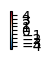

In [59]:
######## New colorbar only for shift + stretch and gaussian ############
x = 5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

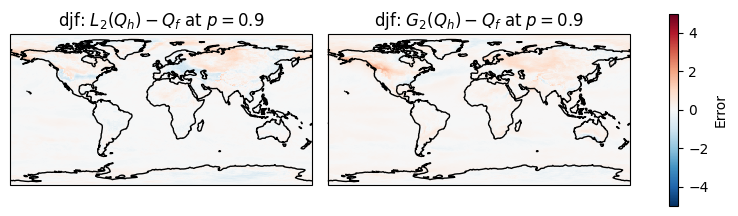

CPU times: user 1.81 s, sys: 23.3 ms, total: 1.83 s
Wall time: 3.94 s


In [60]:
%%time
member =0 
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qmdm_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(season+r': $L_2(Q_h) - Q_f$ at $p=0.9$')

# Plotting G2, gaussian error
im = qgauss_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title(season+': $G_2(Q_h) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Error')

plt.show()

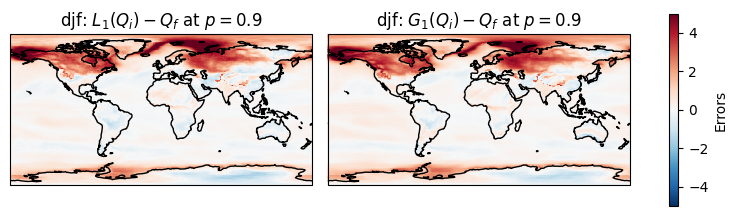

CPU times: user 1.71 s, sys: 61.4 ms, total: 1.77 s
Wall time: 4.53 s


In [61]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qshift_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[0], transform=cart.crs.PlateCarree(),\
                                                    add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
axs[0].set_title(season+': $L_1(Q_i) - Q_f$ at $p=0.9$')

# Plotting da2
im = qgaussmo_err_season.sel(quantile=0.9,method='nearest').isel(member_id=member).mean('dayofyear').plot(ax=axs[1], transform=cart.crs.PlateCarree(),\
                                                          add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
axs[1].set_title(season+r': $G_1(Q_i) - Q_f$ at $p=0.9$')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors')

plt.show()

### Compute ensemble mean of absolute errors

In [ ]:
qmdm_abserr_season = np.abs(qmdm_err_season)

In [63]:
# cluster.close()

In [ ]:
#############################################################################################################